# Insstalling dependencies


In [9]:
#Installing dependencies
! git clone https://github.com/sum33it/scalpy.git
! cd scalpy
! pip install hope
! python ./scalpy/setup.py install

! pip install triangle

fatal: destination path 'scalpy' already exists and is not an empty directory.
  Using cached hope-0.7.3-py3-none-any.whl
running install
running bdist_egg
running egg_info
writing ScalPy.egg-info/PKG-INFO
writing dependency_links to ScalPy.egg-info/dependency_links.txt
writing requirements to ScalPy.egg-info/requires.txt
writing top-level names to ScalPy.egg-info/top_level.txt
package init file 'scalpy/__init__.py' not found (or not a regular file)
listing git files failed - pretending there aren't any
reading manifest file 'ScalPy.egg-info/SOURCES.txt'
writing manifest file 'ScalPy.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib
running build_py
creating build/bdist.macosx-10.9-x86_64/egg
creating build/bdist.macosx-10.9-x86_64/egg/scalpy
copying build/lib/scalpy/setup.py -> build/bdist.macosx-10.9-x86_64/egg/scalpy
byte-compiling build/bdist.macosx-10.9-x86_64/egg/scalpy/setup.py to setup.cpython-38.pyc
creating build/bdist.mac

In [10]:
# First installing emcee

!python -m pip install -U pip
!pip install -U setuptools setuptools_scm pep517
!pip install -U emcee
!pip install astroML
!pip install corner


In [11]:
#lIBRARIES:

import emcee
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from astroML.plotting import plot_mcmc
from astroML.resample import bootstrap
from scipy import optimize
import scalpy
from scalpy.scalpy.fluids import *
import emcee
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as pl
import triangle
from matplotlib.ticker import MaxNLocator

import matplotlib.pyplot as plt
import corner



## Fitting om0, h, ob0 and or0 together in LCDM model from both $\sigma_8$ and JLA data

In [56]:
#from emcee.utils import MPIPool

#####################################################
# JLA data

location = "./scalpy/example/"
#####################################################
dataSN = np.loadtxt(location + 'jla_mub.txt')
zsn = dataSN[:,0]
mu_b = dataSN[:,1]

covdata = np.loadtxt(location + 'jla_mub_covmatrix.dat')
covarray = covdata[1:len(covdata)]

covmat = covarray.reshape(31,31)

def chijla(Om0,h):#,ob0):
	ld = np.vectorize(LCDM(Om0,h).luminosity_distance_z)
	x = 5.0*np.log10(ld(zsn))+25.-mu_b
	covinv = np.linalg.inv(covmat)
	return np.dot(x,np.dot(covinv,x))

######################################################
# fsigma8 data
######################################################
datafs8 = np.loadtxt(location + 'fs8.dat')
zfs8 = datafs8[:,0]
fs8 = datafs8[:,1]
sgm_fs8 = datafs8[:,2]

def chifs8(Om0,h):
	fs8_th = LCDM(Om0,h).fsigma8z(zfs8)
	return np.sum((fs8-fs8_th)**2./sgm_fs8**2)

######################################################
# BAO data
######################################################
covinv = [[0.48435, -0.101383, -0.164945, -0.0305703, -0.097874, -0.106738], [-0.101383, 3.2882, -2.45497, -0.0787898, -0.252254, -0.2751], [-0.164945, -2.454987, 9.55916, -0.128187, -0.410404, -0.447574], [-0.0305703, -0.0787898, -0.128187, 2.78728, -2.75632, 1.16437], [-0.097874, -0.252254, -0.410404, -2.75632, 14.9245, -7.32441], [-0.106738, -0.2751, -0.447574, 1.16437, -7.32441, 14.5022]]

def chibao(Om0,h):#w0,wa):
	cpl = LCDM(Om0,h)#w0,wa)
	Dh = cpl.D_H()
	invdh = 1/Dh
	
	xx = [cpl.comoving_distance_z(1091.)*invdh/((cpl.comoving_distance_z(0.106)*invdh)**2*0.106/(cpl.hubble_normalized_z(0.106)))**(1./3) - 30.95, cpl.comoving_distance_z(1091.)*invdh/((cpl.comoving_distance_z(0.2)*invdh)**2*0.2/(cpl.hubble_normalized_z(0.2)))**(1./3) - 17.55, cpl.comoving_distance_z(1091.)*invdh/((cpl.comoving_distance_z(0.35)*invdh)**2*0.35/(cpl.hubble_normalized_z(0.35)))**(1./3) - 10.11, cpl.comoving_distance_z(1091.)*invdh/((cpl.comoving_distance_z(0.44)*invdh)**2*0.44/(cpl.hubble_normalized_z(0.44)))**(1./3) - 8.44, cpl.comoving_distance_z(1091.)*invdh/((cpl.comoving_distance_z(0.6)*invdh)**2*0.6/(cpl.hubble_normalized_z(0.6)))**(1./3) - 6.69, cpl.comoving_distance_z(1091.)*invdh/((cpl.comoving_distance_z(0.73)*invdh)**2*0.73/(cpl.hubble_normalized_z(0.73)))**(1./3) - 5.45]
	chibao1 = np.dot(xx,np.dot(covinv,xx))
	return chibao1

######################################################
# CMB shift parameter
#####################################################
def Rth(z,Om0,h):#w0,wa):
	cpl = LCDM(Om0,h)#w0,wa)
	Dh = cpl.D_H()
	return np.sqrt(cpl.Omega_m_z(0.))*(1+z)*cpl.angular_diameter_distance_z(z)/Dh

def chishift(Om0,h):#w0,wa):
	return (1.7499-Rth(1090.43,Om0,h))**2/(0.0088**2)
#####################################################

def chi2(Om0,h):
	return chijla(Om0,h)+chifs8(Om0,h)+chibao(Om0,h)#w0,wa)#+chishift(Om0,w0,wa)


def lik(Om0,h):
	return np.exp(-chi2(Om0,h)/2.)

def lnprior(Om0,h):
	if 0.1 < Om0 < 0.9 and 0.3 < h < 1.1:# and 0.0< ob0 < 0.1:
		return 0.0
	return -np.inf
  
def lnlike(Om0,h):
	return np.log(lik(Om0,h))

def lnprob(Om0,h):
	lp = lnprior(Om0,h)
	if not np.isfinite(lp):
		return -np.inf
	return lp + lnlike(Om0,h)

def ff(theta):
	Om0,h=theta
	return -2.*lnprob(Om0,h)

def lnp(theta):
	Om0,h=theta
	return lnprob(Om0,h)



In [58]:

lnprob(0.3,0.7)#, 0.045)

-24.97961539102181

In [60]:


# Find the maximum likelihood value.
result = opt.minimize(ff, [0.3,0.7])


/Users/saba/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [61]:
result["x"]

array([0.27770418, 0.70321428])

In [63]:
Om0_ml,h_ml = result['x']
print("""Maximum likelihood result:
    Om0 = {0} (truth: {1})
    h = {2} (truth: {3})
""".format(Om0_ml, 0.3, h_ml, 0.7))

# Set up the sampler.
ndim, nwalkers = 2, 200

#pos = np.vstack([np.linspace(0.1, 0.9, 200), np.linspace(0.3, 1.1, 200), np.linspace(-3, 3, 200),np.linspace(-0.5, 0.5, 200)]).T

pos = np.array([result['x'] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)])
print("Positions are: ", pos.shape)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnp)
#print pos
# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, 1000)
print("Done.")


Maximum likelihood result:
    Om0 = 0.2777041838508017 (truth: 0.3)
    h = 0.7032142847133581 (truth: 0.7)

Positions are:  (200, 2)
Running MCMC...
Done.


18

<Figure size 432x288 with 0 Axes>

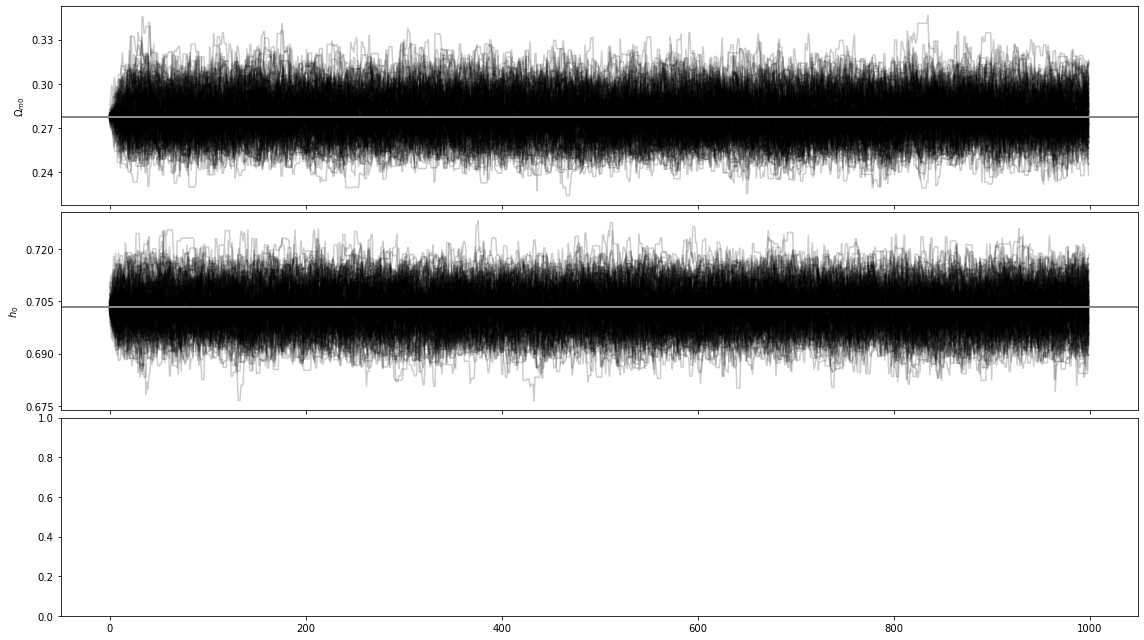

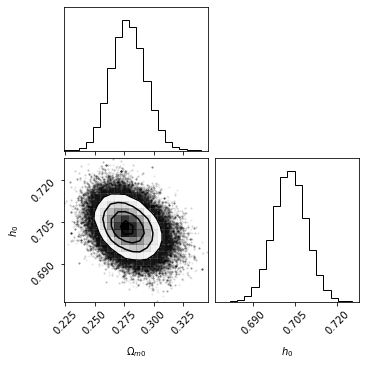

In [65]:

plt.clf()
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(16, 9))
axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.2)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(Om0_ml, color="#888888", lw=2)
axes[0].set_ylabel("$\Omega_{m0}$")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.2)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(h_ml, color="#888888", lw=2)
axes[1].set_ylabel("$h_0$")


# axes[2].plot(sampler.chain[:, :, 2].T, color="k", alpha=0.2)
# axes[2].yaxis.set_major_locator(MaxNLocator(5))
# axes[2].axhline(ob0, color="#888888", lw=2)
# axes[2].set_ylabel("$\Omega_{b0}$")


# axes[1].plot(sampler.chain[:, :, 3].T, color="k", alpha=0.4)
# axes[1].yaxis.set_major_locator(MaxNLocator(5))
# axes[1].axhline(wa_ml, color="#888888", lw=2)
# axes[1].set_ylabel("$w_a$")


fig.tight_layout(h_pad=0.0)
fig.savefig("line-time-chishift_rth_bao_jla_fs8_shift_om0_h.png")

# Make the triangle plot.
burnin = 10
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$\Omega_{m0}$", "$h_0$", "$\Omega_{b0}$"])
fig.savefig("line-triangle_chishift_rth_bao_jla_fs8_shift_om0_h.png")

# Writing samples to a file
length=len(samples[:,0])
test = open("cpl_chishift_rth_bao_jla_fs8_shift_only_h_om0.dat","w")
# for i in range(length):
# 	print( i, samples[:,0][i], samples[:,1][i], samples[:,2][i]
# 	test.write('%s' % (samples[:,0][i],)),
# 	test.write('%s' % (" ")),
# 	test.write('%s' % (samples[:,1][i],)),
# 	test.write('%s' % (" ")),
# 	test.write('%s\n' % (samples[:,2][i],))) 
 
# write maximizing results in a file
test1 = open("ctp_chishift_rth_bao_jla_fs8_shift_only_h_om0","w")
test1.write('%s' % (Om0_ml),)
test1.write('%s' % (" "))
test1.write('%s' % (h_ml),)
